#  Fake data for fiddling

In [1]:
import numpy
import numpy.linalg
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

Let's try and implement SETAR model, or something like that.

In [2]:
NFEAT = 4
NHIST = 60  # past data to switch up on 
NAR = 3     # order of autoregression
NSTAT = 5   # number of states

In [3]:
def make_xpast():
    """Creates past history to prime the time series with.
    """
    return scipy.stats.multivariate_normal.rvs(mean=numpy.zeros(NFEAT), size=NHIST)

In [180]:
def sample(xs, get_params):
    "samples the next sample"
    hist = xs[-NHIST:]
    noise = scipy.stats.multivariate_normal.rvs(mean=numpy.zeros(NFEAT))
    As, B = get_params(hist)
    x = numpy.dot(B, noise)
    for i in range(NAR):
        x += numpy.dot(As[i], hist[-NAR+i])
    return x

def advance(xs, get_params):
    """Samples and appends the sample to the sequence.
    """
    x = sample(xs, get_params)
    xs = numpy.concatenate([xs, x.reshape((1, -1))], axis=0)
    return xs

Let's experiment with fixed parameters first:

In [181]:
def get_fixed_params(hist):
    As = []
    for i in range(NAR):
        A = 1/(NAR*NFEAT) * numpy.eye(NFEAT)
        As.append(A)
    B = 0.1 * numpy.ones(NFEAT)
    return As, B

In [182]:
xs = make_xpast()

In [243]:
for _ in range(60):
    xs = advance(xs, get_fixed_params)
xs[-3:]

array([[-0.27857122, -0.27857122, -0.27857122, -0.27857122],
       [-0.16542493, -0.16542493, -0.16542493, -0.16542493],
       [ 0.19295317,  0.19295317,  0.19295317,  0.19295317]])

Now, instead let's generate random parameters on each call:

In [305]:
GAMMA = 0.8
BETA = 0.2
def get_random_params(hist):
    As = []
    GNORM = sum(GAMMA**(i + 1) for i in range(NAR))
    for i in range(NAR):
        A = scipy.stats.wishart.rvs(df=2 + NFEAT, scale=numpy.eye(NFEAT))
        A = GAMMA**(NAR - i)/GNORM * A/numpy.linalg.det(A)
        As.append(A)
    B = scipy.stats.gamma.rvs(a=2, scale=0.5*BETA, size=NFEAT)
    return As, B

In [306]:
xs = make_xpast()
for _ in range(60):
    xs = advance(xs, get_random_params)
print(xs.max(), xs.min())
xs[-3:]

2.76750400141 -2.32789452844


array([[ 0.19094052,  0.16238338,  0.18497049,  0.16495426],
       [ 0.51311454,  0.65582634,  0.60234558,  0.56057539],
       [ 0.13293479,  0.01559434,  0.10734684,  0.1601792 ]])

Finally we can make that crazy swhitching thing:

In [307]:
ALPHA = 50 # the greater the jumpier
def make_get_switching_params():
    states = [None] * NSTAT
    def get_switching_params(hist):
        i = int(ALPHA*hist.mean()) % NSTAT
        if states[i] is None:
            states[i] = get_random_params(hist)
        return states[i]
    return get_switching_params

We plot four different samples as we generate them, for illustration. This should look like monitor data, superficially. 

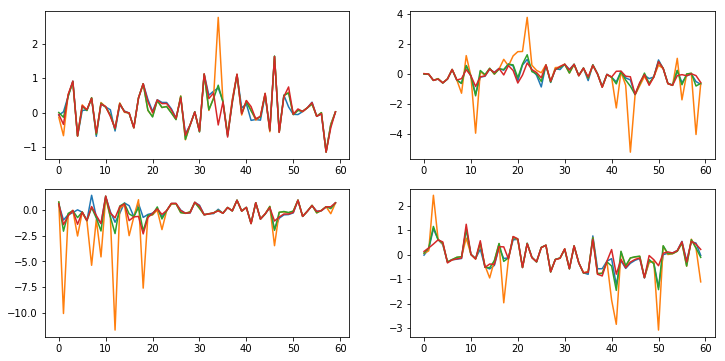

In [311]:
get_switching_params = make_get_switching_params()
xs = make_xpast()
fig, sps = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(6)
for i in range(4):
    for _ in range(60):
        xs = advance(xs, get_switching_params)
    sps[i//2, i%2].plot(xs[-60:])
    xs[-2:]

In [321]:
SAVE = True
if SAVE:
    fig.savefig("../figures/fake-samples.pdf")

Good enough. It only remains to save the time series (and to fiddle with the model).

In [359]:
NSAMPLES = 10000
def standardize(X):
    """Normalizes the data by shifting to zero mean and then applying tanh to smoothen
    outliers.
    """
    X = X - X.mean(axis=0).mean(axis=0)
    X = numpy.tanh(X)
    return X

 First, with shared parameters across all runs.

In [360]:
Xs = []
get_switching_params = make_get_switching_params()
for i in range(NSAMPLES):
    if (i + 1) % 100 == 0:
        print(i + 1, end=" ")
    xs = make_xpast()
    for _ in range(NHIST):
        xs = advance(xs, get_switching_params)
    Xs.append(xs[-NHIST:])
X = numpy.stack(Xs, axis=0)
Xshared = standardize(X)
with open("../data/FAKE/shared", "wb") as f:
    numpy.save(f, Xshared, allow_pickle=False)

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 

Now with independent parameters for each trace:

In [361]:
Xs = []
for i in range(NSAMPLES):
    get_switching_params = make_get_switching_params()
    if (i + 1) % 100 == 0:
        print(i + 1, end=" ")
    xs = make_xpast()
    for _ in range(NHIST):
        xs = advance(xs, get_switching_params)
    Xs.append(xs[-NHIST:])
X = numpy.stack(Xs, axis=0)
Xindependent = standardize(X)
with open("../data/FAKE/independent", "wb") as f:
    numpy.save(f, Xindependent, allow_pickle=False)

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 

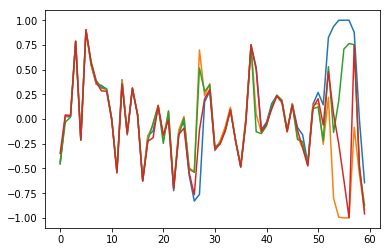

In [356]:
plt.plot(Xshared[5])